# Задание выполнил: Большагин Вячеслав

# EDA

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns

In [28]:

df = pd.read_csv('intern_task.csv', sep=',')
df

,rank,query_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,...,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,feature_130,feature_131,feature_132,feature_133,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143
0,0,10,1.0,0.0,1.0,3.0,3.0,0.333333,0.0,0.333333,0.000000,1.0,10.0,0.0,9.0,11.0,30.0,8.198216,22.240604,18.240926,21.439961,8.194138,0.000000,0.0,1.0,5.0,7.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,2.0,4.0,0.000000e+00,0.0,0.333333,...,0.946833,11.904045,0.0,7.738967,26.350077,22.927740,-19.201910,-20.839029,-17.627562,-7.865720,-9.926361,-22.574108,-24.810069,-21.077948,-20.642055,-19.589214,-21.995388,-23.636237,-20.421283,-6.122882,-8.437561,3.0,76.0,0.0,0.0,153.0,3866.0,17.0,104.0,0.0,0.0,0.000000,0.454545,0.890238,8.655534,1.000000,0.077778,0.002222,1.0,0.333333
1,1,10,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,0.004251,1.0,557.0,0.0,7.0,11.0,575.0,8.198216,22.240604,18.240926,21.439961,8.194138,0.000004,0.0,4.0,0.0,48.0,6.0,0.0,1.0,0.0,7.0,31.0,0.0,2.0,0.0,33.0,8.501341e+00,0.0,1.333333,...,0.792060,23.900332,0.0,21.651734,0.000000,24.339780,-12.018080,-20.839029,-7.961910,-24.026420,-11.733085,-16.087395,-24.810069,-20.081042,-27.079631,-15.792263,-12.102374,-23.636237,-5.459244,-26.827529,-11.848628,3.0,73.0,0.0,9.0,266.0,56137.0,5.0,2.0,0.0,0.0,0.000000,0.000000,0.773976,23.130514,0.000000,0.027826,0.000430,44.0,14.666667
2,0,10,3.0,0.0,2.0,0.0,3.0,1.000000,0.0,0.666667,0.008501,1.0,522.0,0.0,6.0,8.0,536.0,8.198216,22.240604,18.240926,21.439961,8.194138,0.000009,0.0,2.0,0.0,24.0,1.0,0.0,0.0,0.0,1.0,14.0,0.0,1.0,0.0,15.0,1.700268e+01,0.0,0.666667,...,0.918119,21.009703,0.0,15.027157,0.000000,21.160657,-15.320776,-20.839029,-13.173918,-24.026420,-15.174661,-18.149604,-24.810069,-20.741199,-27.079631,-17.982153,-14.476324,-23.636237,-12.939705,-26.827529,-14.353039,4.0,54.0,8.0,0.0,541.0,12621.0,11.0,11.0,0.0,0.0,0.000000,0.000000,0.918308,13.351339,0.000000,0.014925,0.000104,22.0,7.333333
3,1,10,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,0.012752,1.0,59.0,0.0,5.0,5.0,69.0,8.198216,22.240604,18.240926,21.439961,8.194138,0.000013,0.0,3.0,0.0,11.0,2.0,0.0,1.0,0.0,3.0,4.0,0.0,1.0,0.0,5.0,2.550402e+01,0.0,1.000000,...,0.984724,23.622797,0.0,22.468922,0.000000,24.653968,-10.483058,-20.839029,-8.412880,-24.026420,-9.558375,-19.179620,-24.810069,-20.355124,-27.079631,-18.418511,-9.772067,-23.636237,-5.143084,-26.827529,-9.208571,2.0,36.0,6.0,0.0,14687.0,40205.0,5.0,3.0,0.0,0.0,0.000000,0.000000,0.975355,18.240926,0.000000,0.053140,0.000255,8.0,2.666667
4,2,10,3.0,0.0,3.0,1.0,3.0,1.000000,0.0,1.000000,0.017003,1.0,203.0,0.0,7.0,5.0,215.0,8.198216,22.240604,18.240926,21.439961,8.194138,0.000017,0.0,5.0,1.0,30.0,3.0,0.0,1.0,0.0,4.0,11.0,0.0,2.0,1.0,14.0,3.400536e+01,0.0,1.666667,...,0.989615,25.870014,0.0,26.522979,12.696249,26.353970,-10.506004,-20.839029,-6.499347,-19.509025,-9.877307,-16.765195,-24.810069,-19.412571,-23.575400,-16.177233,-10.449261,-23.636237,-4.766107,-22.302319,-9.911815,2.0,21.0,1896.0,1.0,10577.0,34605.0,1.0,1.0,2175.0,273.0,79.670665,0.200000,0.990119,31.786048,0.333333,0.046512,0.000307,24.0,8.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [29]:
df = df.dropna()
df.shape

(235258, 146)

<Axes: xlabel='rank', ylabel='Count'>

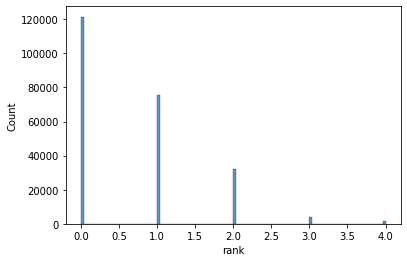

In [30]:
sns.histplot(df['rank'])

In [31]:
print('Среднее количество документво для запроса')
print(np.mean(df['query_id'].value_counts()))

Среднее количество документво для запроса
117.629


In [34]:
# Проверяем как сильное коррелируют между собой признаки
corr_mat = df.drop(columns=['query_id']).corr(method = 'pearson')
upper_corr_mat = corr_mat.where(np.triu(np.ones(corr_mat.shape), k = 1).astype(bool))
unique_corr_pairs = upper_corr_mat.unstack().dropna()
sorted_mat = unique_corr_pairs.sort_values(ascending=False)
corr_90 = sorted_mat[abs(sorted_mat) > 0.90]
print(corr_90.head(10))
corr_left = set([i[0] for i in corr_90.index])
corr_right = set([i[1] for i in corr_90.index])
# сравниваем длины самых коррелирующих чтобы удалить минимальное кол-во признаков
print(len(corr_left))
print(len(corr_right))

feature_35   feature_8      1.000000
feature_20   feature_8      1.000000
feature_35   feature_20     1.000000
feature_19   feature_15     0.999892
feature_74   feature_70     0.999599
feature_94   feature_90     0.999323
feature_142  feature_24     0.999007
feature_123  feature_113    0.997952
feature_121  feature_111    0.997734
feature_119  feature_115    0.997582
dtype: float64
64
70


In [35]:
df_cleaned = df.drop(columns=list(corr_right))
corr_mat = df_cleaned.corr(method = 'pearson')
upper_corr_mat = corr_mat.where(np.triu(np.ones(corr_mat.shape), k = 1).astype(bool))
unique_corr_pairs = upper_corr_mat.unstack().dropna()
sorted_mat = unique_corr_pairs.sort_values()
sorted_mat

feature_121  feature_4     -0.750744
feature_122  feature_18    -0.725049
feature_121  feature_18    -0.720576
feature_124  feature_18    -0.719186
feature_123  feature_4     -0.714120
                              ...   
feature_104  feature_9      0.886055
feature_143  feature_34     0.886712
feature_137  feature_104    0.888117
feature_136  feature_58     0.892348
feature_35   query_id       0.999009
Length: 2556, dtype: float64

Тяжело выделить какой-то однозначный порог корреляция между фичами, но удаление почти половины признаков которые сильно коррелируют уже достаточно, как мне кажется

# Модель

В качестве модели был выбран CatBoost, так как он оптимизирован для gpu (в отличии от того же LightGBM) и имеет модель для ранжирования. Это отличная реализация градиентного бустинга с удобной функциональностью.

In [8]:
%pip install catboost

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [9]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score
from catboost import CatBoostRanker
from catboost import Pool

Для начала можно попробовать обучить модель на не очищенных признаках для проверки гипотезы

In [10]:

# Удалим из датасета уникальные запросы с одним документом, так как их нет смысла ранжировать и не обучить модель для них
df = df[df.groupby('query_id').query_id.transform(len) > 1]
# Разделение данных на обучающую и тестовую выборки
train, test = train_test_split(df, test_size=0.3, random_state=42,
                               stratify=df['query_id'])
print(train.shape)
train = train.sort_values(['query_id'])
test = test.sort_values(['query_id'])

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train.drop(['rank', 'query_id'], axis=1))
print(train_scaled.shape)
test_scaled = scaler.transform(test.drop(['rank', 'query_id'], axis=1))
train_scaled = pd.concat([train['query_id'].reset_index(), pd.DataFrame(train_scaled)], axis=1).drop(columns=['index'])
test_scaled = pd.concat([test['query_id'].reset_index(), pd.DataFrame(test_scaled)], axis=1).drop(columns=['index'])
train_scaled

(164678, 146)
(164678, 144)


,query_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143
0,10,0.096774,0.0,0.125000,0.000000,0.096774,1.0,0.0,1.000000,0.000004,1.0,0.041137,0.000000,0.001209,0.049180,0.042282,0.054778,0.046859,0.043315,0.035604,0.054893,0.000004,0.0,0.019512,0.00000,0.003162,0.007989,0.0,0.009615,0.0,0.009186,0.024314,0.0,0.009950,0.00000,0.025701,0.000004,0.0,0.012821,0.000000,...,0.792060,0.055988,0.0,0.076083,0.000000,0.056680,0.932048,0.938430,0.976930,0.782446,0.933764,0.912848,0.931056,0.943189,0.751573,0.914528,0.930939,0.935964,0.983752,0.790828,0.932497,0.117647,0.063611,0.000000e+00,0.064748,0.002537,0.856594,0.015810,0.007937,0.0,0.000000,0.000000e+00,0.000000,0.773976,0.017773,0.000000,0.045052,0.001720,0.002919,0.019530
1,10,0.096774,0.0,0.125000,0.000000,0.096774,1.0,0.0,1.000000,0.000170,1.0,0.018907,0.000000,0.000691,0.010929,0.019333,0.054778,0.046859,0.043315,0.035604,0.054893,0.000170,0.0,0.014634,0.00000,0.002108,0.011984,0.0,0.009615,0.0,0.013123,0.007843,0.0,0.004975,0.00000,0.008567,0.000170,0.0,0.009615,0.000000,...,0.999858,0.058694,0.0,0.087187,0.000000,0.059067,0.943219,0.938430,0.977547,0.782446,0.944575,0.912707,0.931056,0.942417,0.751573,0.914217,0.942106,0.935964,0.986349,0.790828,0.943359,0.058824,0.006548,8.512357e-06,0.007194,0.795458,0.521729,0.000000,0.003968,0.0,0.000000,0.000000e+00,0.000000,0.999828,0.014016,0.000000,0.065416,0.000012,0.001924,0.012872
2,10,0.096774,0.0,0.083333,0.000000,0.096774,1.0,0.0,0.666667,0.000298,1.0,0.016691,0.000309,0.001209,0.021858,0.017562,0.054778,0.046859,0.043315,0.035604,0.054893,0.000298,0.0,0.009756,0.00000,0.000857,0.003995,0.0,0.000000,0.0,0.005249,0.003137,0.0,0.004975,0.00000,0.003894,0.000298,0.0,0.006410,0.000000,...,0.996442,0.054182,0.0,0.048611,0.000000,0.055175,0.926510,0.938430,0.960943,0.782446,0.929092,0.899102,0.931056,0.941317,0.751573,0.901347,0.927547,0.935964,0.963225,0.790828,0.929540,0.058824,0.034612,3.820056e-07,0.014388,0.401412,0.176366,0.122530,0.059524,0.0,0.000000,0.000000e+00,0.000000,0.998916,0.010259,0.000000,0.029234,0.000016,0.000730,0.004882
3,10,0.096774,0.0,0.125000,0.000000,0.096774,1.0,0.0,1.000000,0.000217,1.0,0.013368,0.000000,0.001036,0.016393,0.014020,0.054778,0.046859,0.043315,0.035604,0.054893,0.000217,0.0,0.014634,0.00000,0.000593,0.001332,0.0,0.009615,0.0,0.002625,0.002353,0.0,0.004975,0.00000,0.003115,0.000217,0.0,0.009615,0.000000,...,0.952443,0.046444,0.0,0.072143,0.000000,0.051474,0.911641,0.938430,0.974054,0.782446,0.924142,0.889446,0.931056,0.942409,0.751573,0.895743,0.919492,0.935964,0.983145,0.790828,0.926494,0.058824,0.011225,8.563291e-07,0.007194,0.313400,0.522263,0.000000,0.003968,0.0,0.000103,9.963206e-08,0.000000,0.875521,0.014016,0.000000,0.025298,0.000080,0.000398,0.002663
4,10,0.096774,0.0,0.125000,0.111111,0.096774,1.0,0.0,1.000000,0.000123,1.0,0.216396,0.000000,0.000864,0.032787,0.217016,0.054778,0.046859,0.043315,0.035604,0.054893,0.000123,0.0,0.019512,0.02381,0.001581,0.007989,0.0,0.009615,0.0,0.009186,0.005490,0.0,0.009950,0.02381,0.007009,0.000123,0.0,0.012821,0.007936,...,0.996124,0.040991,0.0,0.088698,0.206008,0.043557,0.893964,0.938430,0.979830,0.819094,0.898377,0.893769,0.931056,0.943118,0.783679,0.897187,0.893467,0.935964,0.986411,0.822446,0.897436,0.176471,0.035547,0.000000e+00,0.007194,0.094462,0.618427,0.003953,0.011905,0.0,0.000000,0.000000e+00,0.152778,0.998223,0.017625,0.333333,0.004401,0.000000,0.001260,0.008433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164673,29995,0.000000,0.0,0.000000,0

In [11]:
train_pool = Pool(train_scaled, label=train['rank'], group_id=train_scaled['query_id'])
test_pool = Pool(test_scaled, label=test['rank'], group_id=test_scaled['query_id'])

In [288]:
train_pool_gs = Pool(train_scaled, label=train['rank']/4, group_id=train_scaled['query_id'])
ranker_gs = CatBoostRanker(iterations=300, task_type='GPU', custom_metric=['NDCG:top=5;hints=skip_train~false', 'MAP:top=10', 'NDCG:top=10;hints=skip_train~false'], devices='0', loss_function='YetiRank', silent=True)
grid_params = {
    #'loss_function' : ['YetiRank', 'LambdaMart:metric=NDCG', 'StochasticRank', 'QueryCrossEntropy'],
    'depth': [4, 6, 10],
    'l2_leaf_reg': [0, 1, 3, 5],
    'learning_rate': [0.0001, 0.06, 0.6]
}

result = ranker_gs.grid_search(param_grid=grid_params, X=train_pool_gs, plot=True, cv=3)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because PFound, MAP, NDCG is/are not implemented for GPU
Default metric period is 5 because PFound, MAP, NDCG is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MAP:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


bestTest = 0.6465067153
bestIteration = 90
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.6465067	best: 0.6465067 (0)	total: 8.32s	remaining: 4m 51s


Default metric period is 5 because PFound, MAP, NDCG is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MAP:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


bestTest = 0.6777244828
bestIteration = 295
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
1:	loss: 0.6777245	best: 0.6777245 (1)	total: 16.1s	remaining: 4m 33s


Default metric period is 5 because PFound, MAP, NDCG is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MAP:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


bestTest = 0.6887946242
bestIteration = 280
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
2:	loss: 0.6887946	best: 0.6887946 (2)	total: 24.1s	remaining: 4m 25s


Default metric period is 5 because PFound, MAP, NDCG is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MAP:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


bestTest = 0.6349074886
bestIteration = 295
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
3:	loss: 0.6349075	best: 0.6887946 (2)	total: 32.2s	remaining: 4m 17s


Default metric period is 5 because PFound, MAP, NDCG is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MAP:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


bestTest = 0.6745720302
bestIteration = 285
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
4:	loss: 0.6745720	best: 0.6887946 (2)	total: 40s	remaining: 4m 7s


Default metric period is 5 because PFound, MAP, NDCG is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MAP:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


bestTest = 0.6896994976
bestIteration = 215
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
5:	loss: 0.6896995	best: 0.6896995 (5)	total: 48.3s	remaining: 4m 1s


Default metric period is 5 because PFound, MAP, NDCG is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MAP:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


bestTest = 0.6219820606
bestIteration = 295
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
6:	loss: 0.6219821	best: 0.6896995 (5)	total: 56.3s	remaining: 3m 53s


Default metric period is 5 because PFound, MAP, NDCG is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MAP:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


bestTest = 0.6697036023
bestIteration = 299
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
7:	loss: 0.6697036	best: 0.6896995 (5)	total: 1m 4s	remaining: 3m 45s


Default metric period is 5 because PFound, MAP, NDCG is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MAP:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


bestTest = 0.6926779313
bestIteration = 299
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
8:	loss: 0.6926779	best: 0.6926779 (8)	total: 1m 12s	remaining: 3m 37s


Default metric period is 5 because PFound, MAP, NDCG is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MAP:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


bestTest = 0.6040950335
bestIteration = 275
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
9:	loss: 0.6040950	best: 0.6926779 (8)	total: 1m 20s	remaining: 3m 30s


Default metric period is 5 because PFound, MAP, NDCG is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MAP:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


bestTest = 0.6636390463
bestIteration = 299
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
10:	loss: 0.6636390	best: 0.6926779 (8)	total: 1m 28s	remaining: 3m 22s


Default metric period is 5 because PFound, MAP, NDCG is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MAP:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


bestTest = 0.6870310363
bestIteration = 299
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
11:	loss: 0.6870310	best: 0.6926779 (8)	total: 1m 36s	remaining: 3m 13s


Default metric period is 5 because PFound, MAP, NDCG is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MAP:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


bestTest = 0.6527294369
bestIteration = 299
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
12:	loss: 0.6527294	best: 0.6926779 (8)	total: 1m 47s	remaining: 3m 10s


Default metric period is 5 because PFound, MAP, NDCG is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MAP:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


bestTest = 0.6808105434
bestIteration = 285
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
13:	loss: 0.6808105	best: 0.6926779 (8)	total: 1m 58s	remaining: 3m 5s


Default metric period is 5 because PFound, MAP, NDCG is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MAP:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


bestTest = 0.6907601721
bestIteration = 145
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
14:	loss: 0.6907602	best: 0.6926779 (8)	total: 2m 8s	remaining: 2m 59s


Default metric period is 5 because PFound, MAP, NDCG is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MAP:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


bestTest = 0.641340489
bestIteration = 299
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
15:	loss: 0.6413405	best: 0.6926779 (8)	total: 2m 18s	remaining: 2m 53s


Default metric period is 5 because PFound, MAP, NDCG is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MAP:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


bestTest = 0.6769365193
bestIteration = 299
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
16:	loss: 0.6769365	best: 0.6926779 (8)	total: 2m 29s	remaining: 2m 46s


Default metric period is 5 because PFound, MAP, NDCG is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MAP:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


bestTest = 0.6943350298
bestIteration = 285
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
17:	loss: 0.6943350	best: 0.6943350 (17)	total: 2m 39s	remaining: 2m 39s


Default metric period is 5 because PFound, MAP, NDCG is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MAP:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


bestTest = 0.63752869
bestIteration = 265
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
18:	loss: 0.6375287	best: 0.6943350 (17)	total: 2m 49s	remaining: 2m 31s


Default metric period is 5 because PFound, MAP, NDCG is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MAP:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


bestTest = 0.6687603594
bestIteration = 299
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
19:	loss: 0.6687604	best: 0.6943350 (17)	total: 3m	remaining: 2m 24s


Default metric period is 5 because PFound, MAP, NDCG is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MAP:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


bestTest = 0.6922584405
bestIteration = 299
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
20:	loss: 0.6922584	best: 0.6943350 (17)	total: 3m 10s	remaining: 2m 16s


Default metric period is 5 because PFound, MAP, NDCG is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MAP:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


bestTest = 0.6383471746
bestIteration = 299
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
21:	loss: 0.6383472	best: 0.6943350 (17)	total: 3m 21s	remaining: 2m 7s


Default metric period is 5 because PFound, MAP, NDCG is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MAP:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


bestTest = 0.6626499744
bestIteration = 299
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
22:	loss: 0.6626500	best: 0.6943350 (17)	total: 3m 31s	remaining: 1m 59s


Default metric period is 5 because PFound, MAP, NDCG is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MAP:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


bestTest = 0.6902822898
bestIteration = 270
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
23:	loss: 0.6902823	best: 0.6943350 (17)	total: 3m 41s	remaining: 1m 50s


Default metric period is 5 because PFound, MAP, NDCG is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MAP:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


bestTest = 0.6603436396
bestIteration = 195
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
24:	loss: 0.6603436	best: 0.6943350 (17)	total: 4m 25s	remaining: 1m 56s


Default metric period is 5 because PFound, MAP, NDCG is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MAP:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


bestTest = 0.6866091373
bestIteration = 255
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
25:	loss: 0.6866091	best: 0.6943350 (17)	total: 5m 10s	remaining: 1m 59s


Default metric period is 5 because PFound, MAP, NDCG is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MAP:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


bestTest = 0.6920650262
bestIteration = 299
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
26:	loss: 0.6920650	best: 0.6943350 (17)	total: 5m 54s	remaining: 1m 58s


Default metric period is 5 because PFound, MAP, NDCG is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MAP:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


bestTest = 0.6435370656
bestIteration = 55
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
27:	loss: 0.6435371	best: 0.6943350 (17)	total: 6m 41s	remaining: 1m 54s


Default metric period is 5 because PFound, MAP, NDCG is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MAP:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


bestTest = 0.676612518
bestIteration = 299
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
28:	loss: 0.6766125	best: 0.6943350 (17)	total: 7m 28s	remaining: 1m 48s


Default metric period is 5 because PFound, MAP, NDCG is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MAP:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


bestTest = 0.6930100082
bestIteration = 290
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
29:	loss: 0.6930100	best: 0.6943350 (17)	total: 8m 15s	remaining: 1m 39s


Default metric period is 5 because PFound, MAP, NDCG is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MAP:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


bestTest = 0.6374290709
bestIteration = 299
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
30:	loss: 0.6374291	best: 0.6943350 (17)	total: 9m 1s	remaining: 1m 27s


Default metric period is 5 because PFound, MAP, NDCG is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MAP:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


bestTest = 0.671599574
bestIteration = 295
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
31:	loss: 0.6715996	best: 0.6943350 (17)	total: 9m 48s	remaining: 1m 13s


Default metric period is 5 because PFound, MAP, NDCG is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MAP:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


bestTest = 0.6895606858
bestIteration = 299
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
32:	loss: 0.6895607	best: 0.6943350 (17)	total: 10m 34s	remaining: 57.7s


Default metric period is 5 because PFound, MAP, NDCG is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MAP:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


bestTest = 0.6345578468
bestIteration = 299
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
33:	loss: 0.6345578	best: 0.6943350 (17)	total: 11m 20s	remaining: 40s


Default metric period is 5 because PFound, MAP, NDCG is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MAP:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


bestTest = 0.6649104504
bestIteration = 299
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
34:	loss: 0.6649105	best: 0.6943350 (17)	total: 12m 6s	remaining: 20.8s


Default metric period is 5 because PFound, MAP, NDCG is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MAP:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


bestTest = 0.6889948073
bestIteration = 295
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric PFound is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
35:	loss: 0.6889948	best: 0.6943350 (17)	total: 12m 53s	remaining: 0us
Estimating final quality...


Default metric period is 5 because PFound, MAP, NDCG is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MAP:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


Training on fold [0/3]
bestTest = 0.7167206569
bestIteration = 250
Training on fold [1/3]


Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MAP:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


bestTest = 0.7027187169
bestIteration = 250
Training on fold [2/3]


Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MAP:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


bestTest = 0.6955538672
bestIteration = 290


Default metric period is 5 because PFound, MAP, NDCG is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MAP:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


In [12]:
%pip install catboost notebook 


Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 9.0 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.8/116.8 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.3/780.3 kB 39.7 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [12]:
ranker = CatBoostRanker(iterations=7000, 
                        task_type="GPU",
                        devices='0', 
                        depth=10, 
                        loss_function='YetiRank', 
                        metric_period=100,
                        l2_leaf_reg= None,
                        custom_metric=['NDCG:top=5;hints=skip_train~false', 'MAP:top=10', 'NDCG:top=10;hints=skip_train~false'])



# Обучение модели
ranker.fit(train_pool, eval_set=test_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MAP:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7378492	best: 0.7378492 (0)	total: 83.7ms	remaining: 9m 46s
100:	test: 0.7784492	best: 0.7784492 (100)	total: 2.35s	remaining: 2m 40s
200:	test: 0.7843782	best: 0.7843782 (200)	total: 4.5s	remaining: 2m 32s
300:	test: 0.7878452	best: 0.7878452 (300)	total: 6.65s	remaining: 2m 28s
400:	test: 0.7905658	best: 0.7905658 (400)	total: 8.8s	remaining: 2m 24s
500:	test: 0.7925648	best: 0.7925648 (500)	total: 10.9s	remaining: 2m 21s
600:	test: 0.7946838	best: 0.7946838 (600)	total: 13s	remaining: 2m 18s
700:	test: 0.7957708	best: 0.7957708 (700)	total: 15.1s	remaining: 2m 16s
800:	test: 0.7969639	best: 0.7969639 (800)	total: 17.2s	remaining: 2m 13s
900:	test: 0.7977208	best: 0.7977208 (900)	total: 19.3s	remaining: 2m 10s
1000:	test: 0.7980848	best: 0.7980848 (1000)	total: 21.4s	remaining: 2m 8s
1100:	test: 0.7985833	best: 0.7985833 (1100)	total: 23.5s	remaining: 2m 5s
1200:	test: 0.7994758	best: 0.7994758 (1200)	total: 25.6s	remaining: 2m 3s
1300:	test: 0.7999676	best: 0.7999676 (130

## Выгрузка модели в pkl для дальнейшего использования

In [114]:
import pickle

pickle.dump(ranker, open('catRanker.pkl', 'wb'))

In [5]:
import pickle
ranker = pickle.load(open('catRanker.pkl', 'rb'))

# Метрики модели с коррелирующими фичами

In [13]:
# Предсказание рангов для тестовой выборки
preds = ranker.predict(test_scaled)

In [14]:
def apk(actual, predicted, k=10):
    if not actual:
        return 0.0

    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        
        if p == actual[i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)
    
    if num_hits == 0:
        return 0
    return score / num_hits

def mapk(k=10):
    
    apks = []
    for query_id, group in test.groupby('query_id'):
        true_relevance = list(group['rank'].sort_values(ascending=False).index)
        predicted_scores = list(group['preds'].sort_values(ascending=False).index)
        
        try:
            apk_curr = apk(true_relevance, predicted_scores, k)
            apks.append(apk_curr)
        except ValueError as e:
            #print(true_relevance)
            #print(predicted_scores)
            print(e)
            continue
    return np.mean(apks)

In [15]:

from sklearn.metrics import ndcg_score

# Добавление прогнозов в тестовый набор данных
test['preds'] = preds

# Группировка по query_id и вычисление NDCG для каждой группы
ndcg5_scores = []
ndcg50_scores = []
for query_id, group in test.groupby('query_id'):
    true_relevance = group['rank'].values.reshape(1, -1)
    predicted_scores = group['preds'].values.reshape(1, -1)
    try:
        ndcg = ndcg_score(true_relevance, predicted_scores, k=5)
        ndcg5_scores.append(ndcg)
        ndcg50_scores.append(ndcg_score(true_relevance, predicted_scores, k=50))
    except ValueError:
        #print(true_relevance)
        #print(predicted_scores)
        continue
        


# Будем считать по топ-5 и топ-50 документам, т.к. 50 - примерно половина в среднем документов по запросам, поэтому хотелось бы правильно ранжировать верхнюю часть
print(f"Average NDCG@5:  {np.mean(ndcg5_scores)}")
print(f"Average NDCG@50: {np.mean(ndcg50_scores)}")
print(f'Average MAP@5:   {mapk(5)}')
print(f'Average MAP@50:  {mapk(50)}')

Average NDCG@5:  0.5881107326687397
Average NDCG@50: 0.7476370126497026
Average MAP@5:   0.24654899015189452
Average MAP@50:  0.22244712491686655


# Обучение модели с очищенной матрицей

In [36]:
# Удалим из датасета уникальные запросы с одним документом, так как их нет смысла ранжировать и не обучить модель для них
df_cleaned = df_cleaned[df_cleaned.groupby('query_id').query_id.transform(len) > 1]
# Разделение данных на обучающую и тестовую выборки
train, test = train_test_split(df_cleaned, test_size=0.3, random_state=42,
                               stratify=df_cleaned['query_id'])
print(train.shape)
train = train.sort_values(['query_id'])
test = test.sort_values(['query_id'])

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train.drop(['rank', 'query_id'], axis=1))
print(train_scaled.shape)
test_scaled = scaler.transform(test.drop(['rank', 'query_id'], axis=1))
train_scaled = pd.concat([train['query_id'].reset_index(), pd.DataFrame(train_scaled)], axis=1).drop(columns=['index'])
test_scaled = pd.concat([test['query_id'].reset_index(), pd.DataFrame(test_scaled)], axis=1).drop(columns=['index'])
train_pool = Pool(train_scaled, label=train['rank'], group_id=train_scaled['query_id'])
test_pool = Pool(test_scaled, label=test['rank'], group_id=test_scaled['query_id'])

(164678, 76)
(164678, 74)


In [24]:
ranker = CatBoostRanker(iterations=7000, 
                        task_type="GPU",
                        devices='0', 
                        depth=10, 
                        loss_function='YetiRank', 
                        metric_period=100,
                        l2_leaf_reg= None,
                        custom_metric=['NDCG:top=5;hints=skip_train~false', 'MAP:top=10', 'NDCG:top=10;hints=skip_train~false'])



# Обучение модели
ranker.fit(train_pool, eval_set=test_pool, plot=True)
# Предсказание рангов для тестовой выборки
preds = ranker.predict(test_scaled)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7289954	best: 0.7289954 (0)	total: 63.7ms	remaining: 7m 25s


Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MAP:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


100:	test: 0.7788173	best: 0.7788173 (100)	total: 1.74s	remaining: 1m 59s
200:	test: 0.7836218	best: 0.7836218 (200)	total: 3.3s	remaining: 1m 51s
300:	test: 0.7872684	best: 0.7872684 (300)	total: 4.85s	remaining: 1m 47s
400:	test: 0.7891759	best: 0.7891759 (400)	total: 6.42s	remaining: 1m 45s
500:	test: 0.7901834	best: 0.7901834 (500)	total: 7.96s	remaining: 1m 43s
600:	test: 0.7913133	best: 0.7913133 (600)	total: 9.5s	remaining: 1m 41s
700:	test: 0.7928675	best: 0.7928675 (700)	total: 11s	remaining: 1m 39s
800:	test: 0.7941489	best: 0.7941489 (800)	total: 12.6s	remaining: 1m 37s
900:	test: 0.7950618	best: 0.7950618 (900)	total: 14.1s	remaining: 1m 35s
1000:	test: 0.7959735	best: 0.7959735 (1000)	total: 15.6s	remaining: 1m 33s
1100:	test: 0.7961064	best: 0.7961064 (1100)	total: 17.2s	remaining: 1m 31s
1200:	test: 0.7967792	best: 0.7967792 (1200)	total: 18.7s	remaining: 1m 30s
1300:	test: 0.7974583	best: 0.7974583 (1300)	total: 20.2s	remaining: 1m 28s
1400:	test: 0.7980950	best: 0.7980

In [25]:
from sklearn.metrics import ndcg_score

# Добавление прогнозов в тестовый набор данных
test['preds'] = preds

# Группировка по query_id и вычисление NDCG для каждой группы
ndcg5_scores = []
ndcg50_scores = []
for query_id, group in test.groupby('query_id'):
    true_relevance = group['rank'].values.reshape(1, -1)
    predicted_scores = group['preds'].values.reshape(1, -1)
    try:
        ndcg = ndcg_score(true_relevance, predicted_scores, k=5)
        ndcg5_scores.append(ndcg)
        ndcg50_scores.append(ndcg_score(true_relevance, predicted_scores, k=50))
    except ValueError:
        #print(true_relevance)
        #print(predicted_scores)
        continue
        


print(f"Average NDCG@5:  {np.mean(ndcg5_scores)}")
print(f"Average NDCG@50: {np.mean(ndcg50_scores)}")
print(f'Average MAP@5:   {mapk(5)}')
print(f'Average MAP@50:  {mapk(50)}')

Average NDCG@5:  0.5843950929625025
Average NDCG@50: 0.746528344867834
Average MAP@5:   0.24901936237689867
Average MAP@50:  0.21981056667512672


В результате очищения датафрейма метрики остались такими же, что с одной стороны говорит, что модель сама справляется с мультиколлинеарностью и очистка не была нужна (при этом кросс-валидация показала, что модель с l2 регуляризацией показала себя достаточно плохо). С другой же стороны, очищение почти половины признаков не ухудшило метрики, при это время обучения уменьшилось, модель облегчилась.

In [26]:
import pickle

pickle.dump(ranker, open('catRankerCleanedMetrics.pkl', 'wb'))